In [1]:
# matplotlib inline plotting
%matplotlib inline
# make inline plotting higher resolution
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Styling
plt.style.use('ggplot')

### Portfolio construction

* $r_1, r_2$ denotes the returns for both assets - standard deviations are denoted $\sigma_1, \sigma_2$
* Covariance is $Cov(r_1,r_2)$ and correlations is defined as
$$\rho_{12}=\frac{Cov\left(r_{1},r_{2}\right)}{\sigma_{1}\cdot\sigma_{2}}$$
* The fraction of the capital invested in the two assets are denoted $w_1,w_2=(1-w_1)$
* Expected portfolio returns are
$$E(r_p)=w_{1}E\left(r_{1}\right)+\left(1-w_{1}\right)E\left(r_{2}\right)$$
* Portfolio variance is calculated as
$$\sigma_{p}^{2}=w_{1}^{2}\sigma_{1}^{2}+\left(1-w_{1}\right)^{2}\sigma_{2}^{2}+2w_{1}\left(1-w_{1}\right)Cov\left(r_{1},r_{2}\right)$$
* $A$ denotes relative risk-aversion


#### Minimum variance portfolio

The portfolio which yields the lowest possible portfolio-variance (risk) without taking into account expected returns (global minimum-variance portfolio) is found by solving,

$$\min_{w_{1}}\sigma_{p}^{2}=w_{1}^{2}\sigma_{1}^{2}+\left(1-w_{1}\right)^{2}\sigma_{2}^{2}+2w_{1}\left(1-w_{1}\right)\operatorname{Cov}\left(r_{1},r_{2}\right)$$

This is solved by:

\begin{align*}
w_{1}^{\star}&=\frac{\sigma_{2}^{2}-Cov\left(r_{1},r_{2}\right)}{\sigma_{1}^{2}+\sigma_{2}^{2}-2Cov\left(r_{1},r_{2}\right)}\\w_{2}^{\star}&=1-w_{1}^{\star}
\end{align*}


#### Optimal portfolio
The minimum variance portfolio will generally not be the optimal portfolio. Without a risk-free asset the combination of assets depend on the level of risk-aversion. We assume the following utility function and thus following optimization problem,

\begin{align*}
\max_{w_{1}}U&=E\left(r_{p}\right)-\frac{1}{2}A\sigma_{p}^{2}\\\text{ s.t. }\quad E\left(r_{p}\right)&=w_{1}E\left(r_{1}\right)+\left(1-w_{1}\right)E\left(r_{2}\right)\\\sigma_{p}^{2}&=w_{1}^{2}\sigma_{1}^{2}+\left(1-w_{1}\right)^{2}\sigma_{2}^{2}+2w_{1}\left(1-w_{1}\right)Cov\left(r_{1},r_{2}\right)
\end{align*}

This is solved by:

\begin{align*}
w_{1}^{*}&=\frac{E\left(r_{1}\right)-E\left(r_{2}\right)+A\left(\sigma_{2}^{2}-\operatorname{Cov}\left(r_{1},r_{2}\right)\right)}{A\left(\sigma_{1}^{2}+\sigma_{2}^{2}-2\operatorname{Cov}\left(r_{1},r_{2}\right)\right)}\\w_{2}^{*}&=1-w_{1}^{*}
\end{align*}

#### This notebook
With the quite simple math out of the way, we can solve the problem at hand. 

In [2]:
# Settings
ExpectedReturn_AssetA = 0.08
ExpectedReturn_AssetB = 0.13
risk_aversion = 3

std_AssetA = 0.12
std_AssetB = 0.20

correlation_AssetA_AssetB = 0.3
covariance_AssetA_AssetB = std_AssetA * correlation_AssetA_AssetB * std_AssetB

In [3]:
# create different weights for the two assets in increments of .0001
df = pd.DataFrame({'weight_AssetA': np.linspace(0, 1, num=1000)})
df['weight_AssetB'] = 1-df['weight_AssetA']

# calculate optimal portfolio
def optimal_portfolio(e_1, e_2, a, std_1, std_2, cov):
    w_1 = (e_1-e_2 + a*(std_2**2-cov)) / (a*(std_1**2+std_2**2-2*cov))
    w_2 = 1-w_1
    return {'weight_AssetA': w_1, 'weight_AssetB': w_2, }
    

df = df.append(pd.DataFrame(optimal_portfolio(ExpectedReturn_AssetA,
                                              ExpectedReturn_AssetB,
                                              risk_aversion,
                                              std_AssetA,
                                              std_AssetB,
                                              covariance_AssetA_AssetB), index=['optimal']))

# calculate min. variance portfolio
def minvar_portfolio(e_1, e_2, a, std_1, std_2, cov):
    w_1 = (std_2**2 - cov) / (std_1**2 + std_2**2 - 2*cov)
    w_2 = 1-w_1
    return {'weight_AssetA': w_1, 'weight_AssetB': w_2, }
    

df = df.append(pd.DataFrame(minvar_portfolio(ExpectedReturn_AssetA,
                                              ExpectedReturn_AssetB,
                                              risk_aversion,
                                              std_AssetA,
                                              std_AssetB,
                                              covariance_AssetA_AssetB), index=['minvar']))

# Calculate expected returns
df['ExpectedReturn'] = df['weight_AssetA']*ExpectedReturn_AssetA + df['weight_AssetB']*ExpectedReturn_AssetB

def calc_variance(w_1, w_2, e_1, e_2, std_1, std_2, cov):
    return (w_1**2)*(std_1**2)+(w_2**2)*(std_2**2)+2*w_1*w_2*cov

df['Variance'] = calc_variance(w_1=df['weight_AssetB'],
                               w_2=df['weight_AssetA'],
                               e_1=ExpectedReturn_AssetB,
                               e_2=ExpectedReturn_AssetA,
                               std_1=std_AssetB,
                               std_2=std_AssetA,
                               cov=covariance_AssetA_AssetB)

df['Standard_Deviation'] = np.sqrt(df['Variance'])
df = df.sort_values(by='ExpectedReturn')

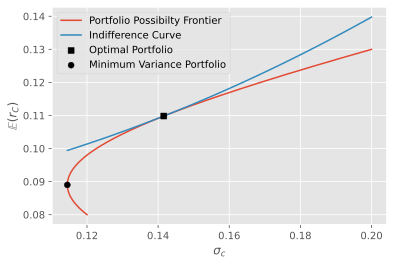

In [4]:
# Plots
def utility_function(E, A, V):
    return E-A*(1/2)*V

def inverse_utility_function(U, A, V):
    return U+A*(1/2)*V

def plot_indifference():
    fixed_util = utility_function(df.loc['optimal']['ExpectedReturn'], 
                                  risk_aversion, 
                                  df.loc['optimal']['Variance'])
    
    return inverse_utility_function(fixed_util, risk_aversion, df['Variance'])

df['Indifference'] = plot_indifference()


plt.xlabel(r'$\sigma_c$')
plt.ylabel(r'$\mathbb{E}(r_C)$')

plt.plot(df['Standard_Deviation'], df['ExpectedReturn'], label='Portfolio Possibilty Frontier')
plt.plot(df['Standard_Deviation'], df['Indifference'], label='Indifference Curve')

# plot min. variance and optimal portfolio
plt.scatter(df.loc['optimal']['Standard_Deviation'], df.loc['optimal']['ExpectedReturn'], 
            zorder=5, marker='s', label='Optimal Portfolio', c='black')
plt.scatter(df.loc['minvar']['Standard_Deviation'], df.loc['minvar']['ExpectedReturn'], 
            zorder=5, marker='o', label='Minimum Variance Portfolio', c='black')

plt.legend()

plt.show()

In [5]:
df.loc[['minvar', 'optimal']]

,weight_AssetA,weight_AssetB,ExpectedReturn,Variance,Standard_Deviation,Indifference
minvar,0.820000,0.180000,0.089000,0.013104,0.114473,0.099417
optimal,0.403333,0.596667,0.109833,0.020048,0.141593,0.109833
